# Generando imágenes de MNIST con GANs

#### Final Project: Tópicos Avanzados en Estadística 1
#### Universidad Nacional de Colombia

__Integrantes:__ Andres Acevedo & Angel Martínez

In [ ]:
#Realizado por: Santiago Acevedo y Angel Martínez
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [ ]:
# Loading the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train:', x_train.shape, '\nx_test:', x_test.shape)

# Scale the inputs in range of (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

x_train: (60000, 28, 28) 
x_test: (10000, 28, 28)


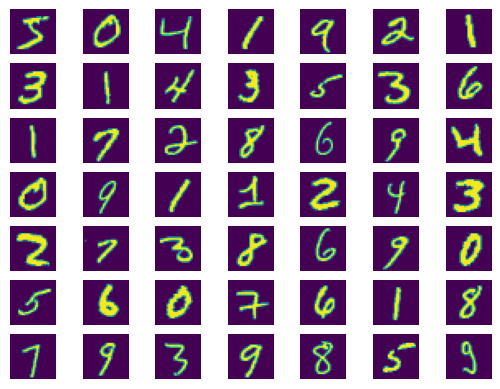

In [ ]:
# Visualizing some examples
for i in range(49):
  plt.subplot(7, 7, i+1)
  plt.axis("off")
  plt.imshow(x_train[i])
plt.show()

In [ ]:
# Flattening and Scaling the data                   (60000,28,28) -> (60000,28*28)
N, H, W = x_train.shape  # number, height, width    (60000,28,28)
print('x_train before:', x_train.shape)
D = H * W   # dimension (28, 28)                    (D=28*28=784)
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)
print('x_train after', x_train.shape)

x_train before: (60000, 28, 28)
x_train after (60000, 784)


In [ ]:
# Defining Generator Model
latent_dim = 100
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))  # 100 from 784
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)  # because Image pixel is between -1 to 1
  model = Model(i, x)  # i is input x is output layer
  return model

Podemos variar algunos hiperparámetros como: `latent_dim` (Input), `alpha` (Leaky ReLU), `momentum` (Batch Norm)

In [ ]:
# Defining the Discriminator Model
def build_discriminator(img_size):  # D = 784
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)  # this is a binary classification (Real or Fake)
  model = Model(i, x)
  return model

In [ ]:
# Build and compile the discriminator
discriminator = build_discriminator(D)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])  # beta -> amount of memory

# Build and compile the combined model
generator = build_generator(latent_dim)

Podemos variar algunos hiperparámetros como: `learning_rate` y `beta` (Adam)

In [ ]:
## Create an input to represent noise sample from latent space
z = Input(shape=(latent_dim,))  # noise

## Pass noise through a generator to get an Image
img = generator(z)  # generated image
discriminator.trainable = False
fake_pred = discriminator(img)

In [ ]:
combined_model_gen = Model(z, fake_pred)  # first is noise and 2nd is fake prediction

# Compile the combined model
combined_model_gen.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [ ]:
# Defining Parameters for the training of GAN
batch_size = 32
epochs = 12000
sample_period = 200  # after how many steps the generator will create a sample
ones = np.ones(batch_size)  # the image is Real
zeros = np.zeros(batch_size)  # the image is Fake

# Store generator and discriminator loss in each step or each epoch
d_losses = []
g_losses = []

# Create a file in which generator will create and save images
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [ ]:
# Function to create Sample Images
def sample_images(epoch):
  rows, cols = 5, 5  # columns and rows in the plot (25 images)
  noise = np.random.randn(rows * cols, latent_dim)  # 25 images of 10 X 10 (in arrays of 100 random values)         (25,100)
  imgs = generator.predict(noise)  # generated images from noise (784 = 28 X 28)                                    (25,784)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  # fig to plot img and axis to store
  idx = 0
  for i in range(rows):  # 5 X 5 loop means on page 25 imgs will be there
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')  # plot the images as 28 X 28 matrix from 784 array     (25,28,28)
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [ ]:
# FIRST we will train Discriminator (with real imgs and fake imgs)

# Main training loop
for epoch in range(epochs):

  ###########################
  ### Train discriminator ###
  ###########################

  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)  # 32 random indices between 0 and 60000
  real_imgs = x_train[idx]  # MNIST dataset

  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)  # generator to generate fake imgs (32 arrays of 100 random values)
  fake_imgs = generator.predict(noise)  # generate images from noise

  # Train the discriminator using train_on_batch
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)  # belong to positive class (real imgs)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)  # fake imgs
  d_loss = 0.5 * (d_loss_real + d_loss_fake)  # loss mean
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)  # accuracy mean

  #######################
  ### Train generator ###
  #######################

  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  # Now we are trying to fool the discriminator that generate imgs are real that's why we are providing label as 1
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model_gen.train_on_batch(noise, ones)

  # Save the losses
  d_losses.append(d_loss)  # save the loss at each epoch
  g_losses.append(g_loss)
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  if epoch % sample_period == 0:
    sample_images(epoch)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
1/1 [==============================] - 0s 22ms/step
epoch: 7101/12000, d_loss: 0.67, d_acc: 0.58, g_loss: 0.77
1/1 [==============================] - 0s 33ms/step
epoch: 7201/12000, d_loss: 0.67, d_acc: 0.59, g_loss: 0.81
1/1 [==============================] - 0s 27ms/step
epoch: 7301/12000, d_loss: 0.67, d_acc: 0.55, g_loss: 0.80
1/1 [==============================] - 0s 27ms/step
epoch: 7401/12000, d_loss: 0.68, d_acc: 0.59, g_loss: 0.79
1/1 [==============================] - 0s 24ms/step
epoch: 7501/12000, d_loss: 0.73, d_acc: 0.45, g_loss: 0.75
1/1 [==============================] - 0s 35ms/step
epoch: 7601/12000, d_loss: 0.70, d_acc: 0.56, g_loss: 0.78
1/1 [==============================] - 0s 29ms/step
epoch: 7701/12000, d_loss: 0.67, d_acc: 0.61, g_loss: 0.75
1/1 [==============================] - 0s 22ms/step
epoch: 7801/12000, d_loss: 0.70, d_acc: 0.48, g_loss: 0.81
1/1 [==============================] - 0s 31m

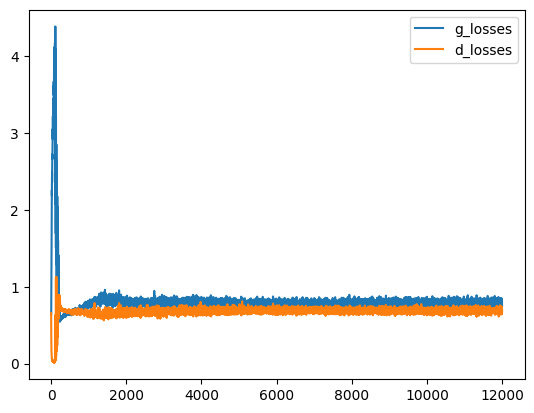

In [ ]:
# Plot Loss Function
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

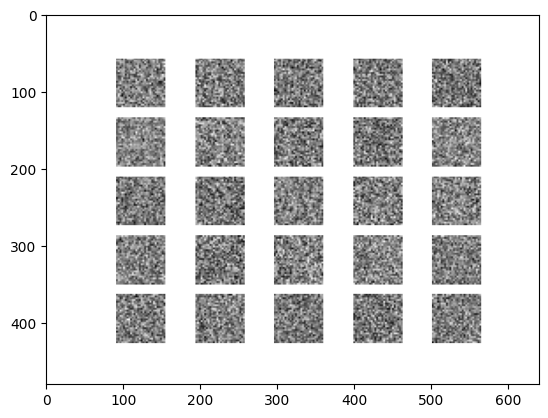

In [ ]:
# Plot the generated Image at zero epoch
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

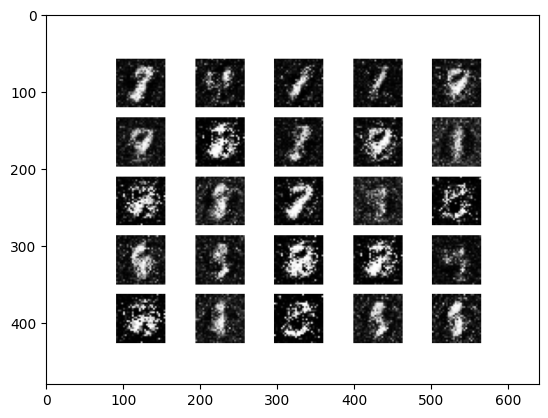

In [ ]:
# Plot Image Generated after training on 1000 epoch
from skimage.io import imread
a = imread('gan_images/1000.png')
plt.imshow(a)

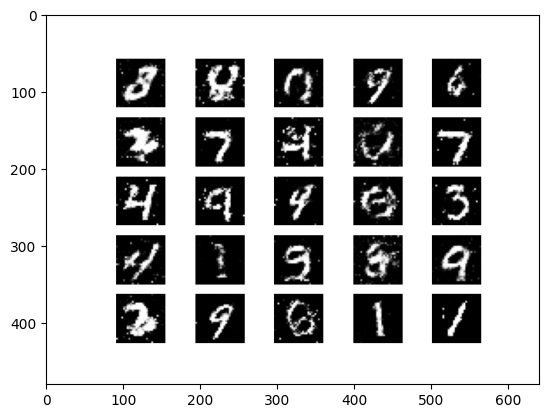

In [ ]:
# Plot Image Generated after training on 10000 epoch
from skimage.io import imread
a = imread('gan_images/10000.png')
plt.imshow(a)